In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
import json

In [33]:
def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

def install_offmom_bpms_colls(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    tw = line.twiss()
    tt = line.get_table()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    colls = []
    aper_to_remove = []
    for nn in offmom_bpms:
        aper_to_remove.append(f'{nn}.a_aper')
        aper_to_remove.append(f'{nn}.b_aper')
        if line[nn+'.a_aper'].__class__.__name__ == 'LimitEllipse':
            jaw = line[nn+'.a_aper'].a
        else:
            jaw = line[nn+'.a_aper'].max_x
        
        colls.append(xc.EverestCollimator(length=line[nn].length, material=xc.materials.Beryllium, jaw=jaw))
    line.remove(aper_to_remove)
    line.collimators.install(names=offmom_bpms, elements=colls)
    return colls

def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tw = line.twiss()
    tt = line.get_table()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

In [133]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt1 = line.get_table()
remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)
tt = line.get_table()
# tw = line.twiss()

#shift VEB apertures by 5.3 mm to account for the sagitta
veb_b_apers = tt.rows['veb.*.b_aper'].name
for name in veb_b_apers:
    line[name].shift_x += 5.3e-3

veb_a_apers = tt.rows['veb.*.a_aper'].name
for name in veb_a_apers:
    line[name].shift_x += 5.3e-3
#Houdt de a aperture steek?
tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [35]:
import apertls
ap_calc = apertls.ApertureCalculator(line)
x_ext = ap_calc.compute_x_extent()

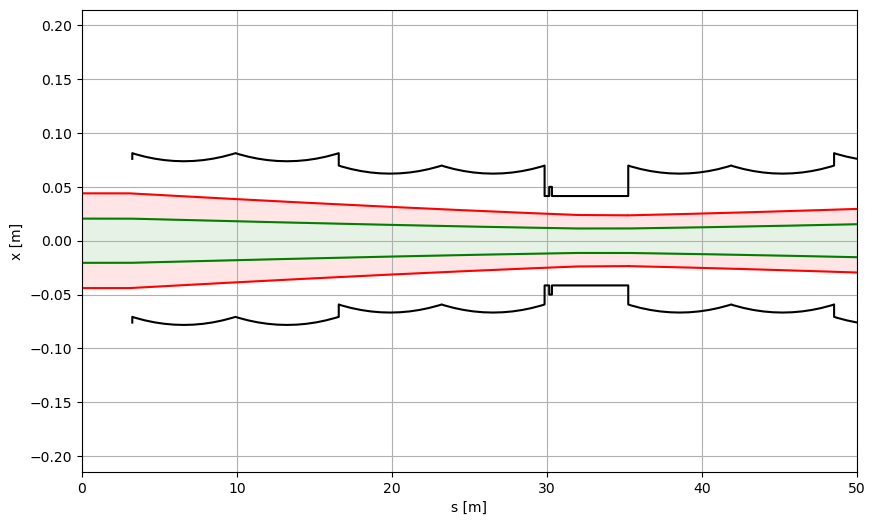

In [36]:
exn=3.5e-6
nrj=21
pmass=0.938
bucket_height=3e-3
n_buckets = 1

mask = np.array([line[nn].__class__.__name__.startswith('Limit') for nn in tt.name[:-1]])
mask = np.concatenate((mask, [False]))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tt.s[mask], x_ext[:, 0], '-', color='k')
ax.plot(tt.s[mask], x_ext[:, 1], '-', color='k')
ax.plot(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj), color='green', label='5 sigma')
ax.plot(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj), color='green')

ax.plot(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx, color='red', label='5 sigma + bucket')
ax.plot(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj)-n_buckets*bucket_height*tw.dx, color='red')

ax.fill_between(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj), 5*np.sqrt(tw.betx*exn*pmass/nrj), color='green', alpha=0.1)
ax.fill_between(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj)-n_buckets*bucket_height*tw.dx, -5*np.sqrt(tw.betx*exn*pmass/nrj), color='red', alpha=0.1)
ax.fill_between(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx, 5*np.sqrt(tw.betx*exn*pmass/nrj), color='red', alpha=0.1)
ax.grid()
# ax.legend()
# ax.set_xlim(23,33)
ax.set_xlim(0, 50)
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.hlines(0.02, 5200, 6200)
# plt.savefig('x_extent_with_bucket.pdf', dpi=300)
plt.show()

In [14]:
tt.s > 23

array([False, False, False, ...,  True,  True,  True], shape=(32247,))

# Aperture markers for flanges
Not correct: apertures are in the middle of active elements

In [8]:
L1 = 34e-3
L2 = 70e-3

r1 = 41.5e-3
r2 = 60e-3-1.5e-3
r3 = 51.5e-3

changed = [10110, 11110, 11310, 12510, 13510, 20910, 21110, 22510, 23510, 30110, 30910,
32510, 33510, 40110, 40910, 41110, 42510, 42710, 51110, 52510, 53510, 60110,
61110, 62510, 63510]

In [45]:
env = line.env

insertions = []
for nn in changed:
    nn_flange = f'vcak.{nn-9}.a_aper'
    line[nn_flange].shift_x +=5.3e-3

    #Add apertures for intermediate flanges
    start_flange = line.get_s_position(nn_flange)
    
    s_aper_c = start_flange + L1
    s_aper_d = start_flange + L1

    s_aper_e = start_flange + L1 + L2
    s_aper_f = start_flange + L1 + L2
    
    env.elements[f'vcak.{nn-9}.c_aper'] = xt.LimitEllipse(a=r1, b=r1, shift_x = 5.3e-3)
    insertions.append(env.place(f'vcak.{nn-9}.c_aper', at=s_aper_c))
    env.elements[f'vcak.{nn-9}.d_aper'] = xt.LimitEllipse(a=r2, b=r2)
    insertions.append(env.place(f'vcak.{nn-9}.d_aper', at=s_aper_d))

    env.elements[f'vcak.{nn-9}.e_aper'] = xt.LimitEllipse(a=r2, b=r2)
    insertions.append(env.place(f'vcak.{nn-9}.e_aper', at=s_aper_e))
    env.elements[f'vcak.{nn-9}.f_aper'] = xt.LimitEllipse(a=r1, b=r1)
    insertions.append(env.place(f'vcak.{nn-9}.f_aper', at=s_aper_f))
    
line.insert(insertions, s_tol=1e-6)

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

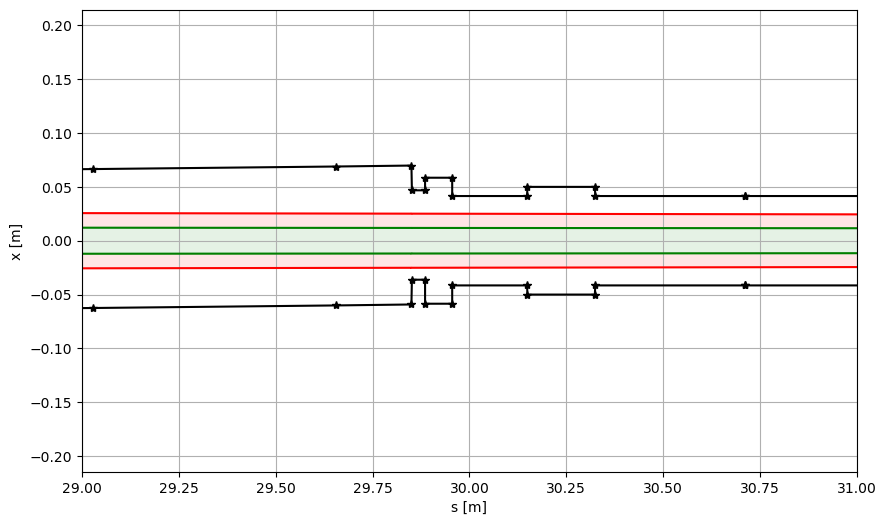

In [46]:
exn=3.5e-6
nrj=21
pmass=0.938
bucket_height=3e-3
n_buckets = 1

ap_calc = apertls.ApertureCalculator(line)
x_ext = ap_calc.compute_x_extent()
tt = line.get_table()
mask = np.array([line[nn].__class__.__name__.startswith('Limit') for nn in tt.name[:-1]])
mask = np.concatenate((mask, [False]))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tt.s[mask], x_ext[:, 0], '*-', color='k')
ax.plot(tt.s[mask], x_ext[:, 1], '*-', color='k')
ax.plot(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj), color='green', label='5 sigma')
ax.plot(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj), color='green')

ax.plot(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx, color='red', label='5 sigma + bucket')
ax.plot(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj)-n_buckets*bucket_height*tw.dx, color='red')

ax.fill_between(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj), 5*np.sqrt(tw.betx*exn*pmass/nrj), color='green', alpha=0.1)
ax.fill_between(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj)-n_buckets*bucket_height*tw.dx, -5*np.sqrt(tw.betx*exn*pmass/nrj), color='red', alpha=0.1)
ax.fill_between(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx, 5*np.sqrt(tw.betx*exn*pmass/nrj), color='red', alpha=0.1)
ax.grid()
# ax.legend()
ax.set_xlim(29,31)
# ax.set_xlim(0, 50)
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.hlines(0.02, 5200, 6200)
# plt.savefig('x_extent_with_bucket.pdf', dpi=300)
plt.show()

# Collimators

In [ ]:
def install_offmom_bpms_colls(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    tw = line.twiss()
    tt = line.get_table()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    colls = []
    aper_to_remove = []
    for nn in offmom_bpms:
        aper_to_remove.append(f'{nn}.a_aper')
        aper_to_remove.append(f'{nn}.b_aper')
        if line[nn+'.a_aper'].__class__.__name__ == 'LimitEllipse':
            jaw = line[nn+'.a_aper'].a
        else:
            jaw = line[nn+'.a_aper'].max_x
        
        colls.append(xc.EverestCollimator(length=line[nn].length, material=xc.materials.Beryllium, jaw=jaw))
    line.remove(aper_to_remove)
    line.collimators.install(names=offmom_bpms, elements=colls)
    return colls

In [57]:
tt.rows[(tt.s>29) & (tt.s<30.2)]

Table: 21 rows, 11 cols
name                            s element_type       isthick isreplica parent_name iscollective ...
mbb.10090..9_aper2         29.029 LimitRect            False     False None               False
mbb.10090..9               29.029 ThickSliceRBend       True     False mbb.10090          False
mbb.10090..10_aper2        29.655 LimitRect            False     False None               False
mbb.10090..exit_map        29.655 ThinSliceRBendExit   False     False mbb.10090          False
mbb.10090_exit             29.655 Marker               False     False None               False
drift_4..0                 29.655 DriftSlice            True     False drift_4            False
vebb.10090.b_aper         29.8504 LimitRect            False     False None               False
drift_4..1                29.8504 DriftSlice            True     False drift_4            False
vcak.10101.a_aper         29.8516 LimitEllipse         False     False None               False
drift_4..2..

In [63]:
colls = []
colls_names = []
colls_positions = []
def get_end_drift(letter):
    if letter == 'a':
        return 'c'
    elif letter == 'd':
        return 'e'
    elif letter == 'f':
        return 'b'
    else:
        raise ValueError('Letter must be a, d, or f')

for nn in changed:
    nn_flange = f'vcak.{nn-9}'

    for i, letter in enumerate(['a', 'd', 'f']):
        ss_flange = line.get_s_position(f'{nn_flange}.{letter}_aper')
        if line[f'{nn_flange}.{letter}_aper'].__class__.__name__ == 'LimitEllipse':
            jaw = line[f'{nn_flange}.{letter}_aper'].a
        else:
            jaw = line[f'{nn_flange}.{letter}_aper'].max_x
        length = line.get_s_position(f'{nn_flange}.{get_end_drift(letter)}_aper') - ss_flange
        colls.append(xc.EverestCollimator(length=length, material=xc.materials.Glidcop, jaw=jaw))
        colls_names.append(f'{nn_flange}.coll..{i}')
        colls_positions.append(ss_flange)
line.collimators.install(names=colls_names, elements=colls, at_s=colls_positions)

Slicing line:   0%|          | 0/32420 [00:00<?, ?it/s]

In [64]:
tt.rows['vcak.13501.*']

Table: 6 rows, 11 cols
name                          s element_type isthick isreplica parent_name iscollective ...
vcak.13501.a_aper       1117.77 LimitEllipse   False     False None               False
vcak.13501.c_aper       1117.81 LimitEllipse   False     False None               False
vcak.13501.d_aper       1117.81 LimitEllipse   False     False None               False
vcak.13501.e_aper       1117.88 LimitEllipse   False     False None               False
vcak.13501.f_aper       1117.88 LimitEllipse   False     False None               False
vcak.13501.b_aper       1118.63 LimitEllipse   False     False None               False

In [66]:
np.where(tt.name == 'vcak.13501.a_aper')

(array([5198]),)

In [68]:
tt.name[5198-2:5198+15]

array(['vebb.13490.b_aper', 'drift_299..1', 'vcak.13501.a_aper',
       'drift_299..2..0', 'vcak.13501.c_aper', 'vcak.13501.d_aper',
       'drift_299..2..1', 'lod.13502_entry', 'lod.13502..entry_map',
       'lod.13502..0', 'vcak.13501.e_aper', 'vcak.13501.f_aper',
       'lod.13502..1', 'lod.13502..exit_map', 'lod.13502_exit',
       'drift_300..0', 'vcak.13501.b_aper'], dtype=object)

In [71]:
tt.rows['vcak.13501.a_aper<<4':'vcak.13501.a_aper>>15']

Table: 20 rows, 11 cols
name                             s element_type           isthick isreplica parent_name ...
mbb.13490_exit             1117.58 Marker                   False     False None       
drift_299..0               1117.58 DriftSlice                True     False drift_299  
vebb.13490.b_aper          1117.77 LimitRect                False     False None       
drift_299..1               1117.77 DriftSlice                True     False drift_299  
vcak.13501.a_aper          1117.77 LimitEllipse             False     False None       
drift_299..2..0            1117.77 DriftSlice                True     False drift_299  
vcak.13501.c_aper          1117.81 LimitEllipse             False     False None       
vcak.13501.d_aper          1117.81 LimitEllipse             False     False None       
drift_299..2..1            1117.81 DriftSlice                True     False drift_299  
lod.13502_entry            1117.88 Marker                   False     False None       
lod.

# New collimators

In [72]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)
tt = line.get_table()
# tw = line.twiss()

#shift VEB apertures by 5.3 mm to account for the sagitta
veb_b_apers = tt.rows['veb.*.b_aper'].name
for name in veb_b_apers:
    line[name].shift_x += 5.3e-3

veb_a_apers = tt.rows['veb.*.a_aper'].name
for name in veb_a_apers:
    line[name].shift_x += 5.3e-3
#Houdt de a aperture steek?
tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [73]:
L1 = 34e-3
L2 = 70e-3

r1 = 41.5e-3
r2 = 60e-3-1.5e-3
r3 = 51.5e-3

changed = [10110, 11110, 11310, 12510, 13510, 20910, 21110, 22510, 23510, 30110, 30910,
32510, 33510, 40110, 40910, 41110, 42510, 42710, 51110, 52510, 53510, 60110,
61110, 62510, 63510]

In [74]:
tt.rows['vcak.13501.a_aper<<2':'vcak.13501.a_aper>>15']

Table: 18 rows, 11 cols
name                              s element_type isthick isreplica parent_name        iscollective ...
vebb.13490.b_aper           1117.77 LimitRect      False     False None                      False
drift_299..1                1117.77 DriftSlice      True     False drift_299                 False
vcak.13501.a_aper           1117.77 LimitEllipse   False     False None                      False
drift_299..2                1117.77 DriftSlice      True     False drift_299                 False
lod.13502                   1117.88 Octupole        True     False None                      False
drift_300..0                1118.55 DriftSlice      True     False drift_300                 False
vcak.13501.b_aper           1118.63 LimitEllipse   False     False None                      False
drift_300..1                1118.63 DriftSlice      True     False drift_300                 False
vtto.13505.a_aper           1118.63 LimitEllipse   False     False None          

In [81]:
apers = tt.rows['vcak.13501.*._aper'].name
positions = [line.get_s_position(name) for name in apers]
tt.name[(tt.s > positions[0]) & (tt.s < positions[-1])]

array(['lod.13502', 'drift_300..0'], dtype=object)

In [ ]:
line['vcak.13501.a_aper'].to_dict() == line['vcak.13501.b_aper'].to_dict()

{'__class__': 'LimitEllipse',
 'a_squ': np.float64(0.0017222500000000003),
 'a_b_squ': np.float64(2.966145062500001e-06),
 'b_squ': np.float64(0.0017222500000000003),
 'a': np.float64(0.0415),
 'b': np.float64(0.0415)}

In [104]:
env = line.env
aper_start = 'vcak.13501.a_aper'
aper_end = 'vcak.13501.b_aper'
for nn, ee in zip(tt.rows[f'{aper_start}>>1':aper_end].name, tt.rows[f'{aper_start}>>1':aper_end].element_type):
    if ee.startswith('Drift') or ee.startswith('Marker'):
        continue
    elif ee.startswith('Limit'):
        next_aper = nn
        break
    else:
        raise ValueError(f'Unexpected element type {ee} for element {nn}')
next_aper

'lod.13502_aper_enter'

In [ ]:
env = line.env
aper_start = 'vcak.13501.a_aper'
aper_end = 'vcak.13501.b_aper'
insertions = []
for nn, ee in zip(tt.rows[aper_start:aper_end].name, tt.rows[aper_start:aper_end].element_type):
    if not ee.startswith('Limit') and not ee.startswith('Drift') and not ee.startswith('Marker'):
        env.elements[f'{nn}_aper_enter'] = line['vcak.13501.a_aper'].copy()
        env.elements[f'{nn}_aper_exit'] = line['vcak.13501.b_aper'].copy()
        insertions.append(env.place(f'{nn}_aper_enter', at=f'{nn}@start'))
        insertions.append(env.place(f'{nn}_aper_exit', at=f'{nn}@end'))
line.insert(insertions, s_tol=1e-6)

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [102]:
tt = line.get_table()

In [103]:
tt.rows['vcak.13501.a_aper<<2':'vcak.13501.a_aper>>15']

Table: 18 rows, 11 cols
name                              s element_type isthick isreplica parent_name        iscollective ...
vebb.13490.b_aper           1117.77 LimitRect      False     False None                      False
drift_299..1                1117.77 DriftSlice      True     False drift_299                 False
vcak.13501.a_aper           1117.77 LimitEllipse   False     False None                      False
drift_299..2                1117.77 DriftSlice      True     False drift_299                 False
lod.13502_aper_enter        1117.88 LimitEllipse   False     False None                      False
lod.13502                   1117.88 Octupole        True     False None                      False
lod.13502_aper_exit         1118.55 LimitEllipse   False     False None                      False
drift_300..0                1118.55 DriftSlice      True     False drift_300                 False
vcak.13501.b_aper           1118.63 LimitEllipse   False     False None          

## Placing apertures where missing in changed flanges

In [161]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)
tt = line.get_table()
# tw = line.twiss()

#shift VEB apertures by 5.3 mm to account for the sagitta
veb_b_apers = tt.rows['veb.*.b_aper'].name
for name in veb_b_apers:
    line[name].shift_x += 5.3e-3

veb_a_apers = tt.rows['veb.*.a_aper'].name
for name in veb_a_apers:
    line[name].shift_x += 5.3e-3
#Houdt de a aperture steek?
tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [162]:
tt.rows['vcak.13501.*']

Table: 2 rows, 11 cols
name                          s element_type isthick isreplica parent_name iscollective ...
vcak.13501.a_aper       1117.77 LimitEllipse   False     False None               False
vcak.13501.b_aper       1118.63 LimitEllipse   False     False None               False

In [163]:
env = line.env
insertions = []
for qd_number in changed:
    flange_number = qd_number - 9
    
    aper_start = f'vcak.{flange_number}.a_aper'
    aper_end = f'vcak.{flange_number}.b_aper'

    for nn, ee in zip(tt.rows[aper_start:aper_end].name, tt.rows[aper_start:aper_end].element_type):
        if not ee.startswith('Limit') and not ee.startswith('Drift') and not ee.startswith('Marker'):
            env.elements[f'{nn}_aper_enter'] = line['vcak.13501.a_aper'].copy()
            env.elements[f'{nn}_aper_exit'] = line['vcak.13501.b_aper'].copy()
            insertions.append(env.place(f'{nn}_aper_enter', at=f'{nn}@start'))
            insertions.append(env.place(f'{nn}_aper_exit', at=f'{nn}@end'))
line.insert(insertions, s_tol=1e-6)

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [164]:
tt = line.get_table()
print(line.get_s_position('vcak.13501.a_aper'))
tt.rows['vcak.13501.a_aper<<5':'vcak.13501.a_aper>>5']
# tw = line.twiss()

1117.7732


Table: 11 rows, 11 cols
name                             s element_type       isthick isreplica parent_name iscollective ...
mbb.13490..exit_map        1117.58 ThinSliceRBendExit   False     False mbb.13490          False
mbb.13490_exit             1117.58 Marker               False     False None               False
drift_299..0               1117.58 DriftSlice            True     False drift_299          False
vebb.13490.b_aper          1117.77 LimitRect            False     False None               False
drift_299..1               1117.77 DriftSlice            True     False drift_299          False
vcak.13501.a_aper          1117.77 LimitEllipse         False     False None               False
drift_299..2               1117.77 DriftSlice            True     False drift_299          False
lod.13502_aper_enter       1117.88 LimitEllipse         False     False None               False
lod.13502                  1117.88 Octupole              True     False None               False
lo

In [141]:
start_flange_apers = []
end_flange_apers = []
for qd_number in changed:
    flange_number = qd_number - 9
    
    aper_start = f'vcak.{flange_number}.a_aper'
    aper_end = f'vcak.{flange_number}.b_aper'

    for nn, ee in zip(tt.rows[f'{aper_start}>>1':aper_end].name, tt.rows[f'{aper_start}>>1':aper_end].element_type):
        if ee.startswith('Drift') or ee.startswith('Marker'):
            continue
        elif ee.startswith('Limit'):
            next_aper = nn
            break
        else:
            raise ValueError(f'Unexpected element type {ee} for element {nn}')
    end_flange_apers.append(next_aper)
    start_flange_apers.append(aper_start)

In [142]:
tt = line.get_table()
tt.rows['vcak.13501.*']
# tw = line.twiss()

Table: 2 rows, 11 cols
name                          s element_type isthick isreplica parent_name iscollective ...
vcak.13501.a_aper       1117.77 LimitEllipse   False     False None               False
vcak.13501.b_aper       1118.63 LimitEllipse   False     False None               False

In [144]:
line.get_length()

np.float64(6908.37379999983)

In [143]:
flange_numbers = [nn-9 for nn in changed]

In [159]:
line.get_s_position('vcak.13501.coll..0')

np.float64(1117.7562000000003)

In [166]:
L1 = 34e-3
line.env.elements['vcak.13501.coll..0'] = xc.EverestCollimator(length=L1, material=xc.materials.Glidcop, jaw=r1-5.3e-3)
line.insert(env.place('vcak.13501.coll..0', at=f'vcak.13501.a_aper@end', anchor='start'), s_tol=1e-6)
print(line.get_length())
# line.get_table().rows['vcak.13501.a_aper':'vcak.13501.a_aper>>5']
line.get_table().rows['vcak.13501.coll..0<<5':'vcak.13501.coll..0>>5']

Slicing line:   0%|          | 0/32258 [00:00<?, ?it/s]

6908.373799999831


Table: 11 rows, 11 cols
name                             s element_type      isthick isreplica parent_name iscollective ...
mbb.13490_exit             1117.58 Marker              False     False None               False
drift_299..0               1117.58 DriftSlice           True     False drift_299          False
vebb.13490.b_aper          1117.77 LimitRect           False     False None               False
drift_299..1               1117.77 DriftSlice           True     False drift_299          False
vcak.13501.a_aper          1117.77 LimitEllipse        False     False None               False
vcak.13501.coll..0         1117.77 EverestCollimator    True     False None               False
drift_299..2..1            1117.81 DriftSlice           True     False drift_299          False
lod.13502_aper_enter       1117.88 LimitEllipse        False     False None               False
lod.13502                  1117.88 Octupole             True     False None               False
lod.13502_ap

In [167]:
L1 = 34e-3
L2 = 70e-3

r1 = 41.5e-3
r2 = 60e-3-1.5e-3
r3 = 51.5e-3
# line.env.elements['vcak.13501.coll..0'] = xc.EverestCollimator(length=L1, material=xc.materials.Glidcop, jaw=r1-5.3e-3)
# line.insert(env.place('vcak.13501.coll..0', at=f'vcak.13501.a_aper@end', anchor='start'), s_tol=1e-6)
line.env.elements['vcak.13501.coll..1'] = xc.EverestCollimator(length=L2, material=xc.materials.Glidcop, jaw=r2)
line.insert(env.place('vcak.13501.coll..1', at=f'vcak.13501.coll..0@end', anchor='start'), s_tol=1e-6)
print(line.get_length())
# line.get_table().rows['vcak.13501.a_aper':'vcak.13501.a_aper>>5']
line.get_table().rows['vcak.13501.coll..0<<5':'vcak.13501.coll..0>>5']

Slicing line:   0%|          | 0/32259 [00:00<?, ?it/s]

6908.373799999831


Table: 11 rows, 11 cols
name                            s element_type          isthick isreplica parent_name iscollective ...
mbb.13490_exit            1117.58 Marker                  False     False None               False
drift_299..0              1117.58 DriftSlice               True     False drift_299          False
vebb.13490.b_aper         1117.77 LimitRect               False     False None               False
drift_299..1              1117.77 DriftSlice               True     False drift_299          False
vcak.13501.a_aper         1117.77 LimitEllipse            False     False None               False
vcak.13501.coll..0        1117.77 EverestCollimator        True     False None               False
vcak.13501.coll..1        1117.81 EverestCollimator        True     False None               False
lod.13502..1              1117.88 ThickSliceOctupole       True     False lod.13502          False
lod.13502..exit_map       1118.55 ThinSliceOctupoleExit   False     False lod.135

In [172]:
line['lod.13502..1'].weight

np.float64(0.9973412112239776)

In [123]:
L1 = 34e-3
L2 = 70e-3

r1 = 41.5e-3
r2 = 60e-3-1.5e-3
r3 = 51.5e-3

colls = []
colls_names = []
colls_positions = []
line.discard_tracker()
for nn, start, end in zip(flange_numbers, start_flange_apers, end_flange_apers):
    colls_positions += [line.get_s_position(start), line.get_s_position(start)+L1, line.get_s_position(start)+L1+L2]
    colls_names += [f'vcak.{nn}.coll..0', f'vcak.{nn}.coll..1', f'vcak.{nn}.coll..2']
    
    colls += [xc.EverestCollimator(length=L1, material=xc.materials.Glidcop, jaw=r1-5.3e-3),
                xc.EverestCollimator(length=L2, material=xc.materials.Glidcop, jaw=r2),
                xc.EverestCollimator(length=line.get_s_position(end)-line.get_s_position(start)-L1-L2, material=xc.materials.Glidcop, jaw=r3)]
line.collimators.install(names=colls_names, elements=colls, at_s=colls_positions)

Slicing line:   0%|          | 0/32258 [00:00<?, ?it/s]

In [126]:
tt = line.get_table()
tt.rows['vcak.13501.a_aper<<5':'vcak.13501.a_aper>>5']
# tw = line.twiss()

Table: 11 rows, 11 cols
name                            s element_type          isthick isreplica parent_name iscollective ...
mbb.13490..exit_map       1117.58 ThinSliceRBendExit      False     False mbb.13490          False
mbb.13490_exit            1117.58 Marker                  False     False None               False
drift_299..0              1117.58 DriftSlice               True     False drift_299          False
vebb.13490.b_aper         1117.77 LimitRect               False     False None               False
drift_299..1              1117.77 DriftSlice               True     False drift_299          False
vcak.13501.a_aper         1117.77 Drift                    True     False None               False
vcak.13501.coll..0        1117.77 EverestCollimator        True     False None               False
vcak.13501.coll..1        1117.81 EverestCollimator        True     False None               False
vcak.13501.coll..2        1117.88 EverestCollimator        True     False None   

In [125]:
line['vcak.13501.a_aper']

View of Drift(length=0, _model=np.int64(0))

In [114]:
tt = line.get_table()

In [115]:
tt.rows['vcak.13501.*']

Table: 5 rows, 11 cols
name                           s element_type      isthick isreplica parent_name iscollective ...
vcak.13501.a_aper        1117.77 Drift                True     False None               False
vcak.13501.coll..0       1117.77 EverestCollimator    True     False None               False
vcak.13501.coll..1       1117.81 EverestCollimator    True     False None               False
vcak.13501.coll..2       1117.88 EverestCollimator    True     False None               False
vcak.13501.b_aper        1117.95 LimitEllipse        False     False None               False

# Other insert because bug in line install collimators

Flange staat in de sextupool/octupool. Dus moeten we dat element slicen als het nodig is, om verder te kunnen. Frederik zegt om in 5 te slicen...

Script om automatisch te recognisen of er gesliced moet worden of niet, dus eerst de pipe definieren...